# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.14.0'

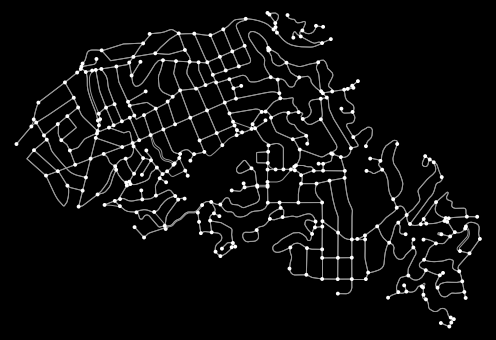

In [2]:
# get a graph for some city
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
fig, ax = ox.plot_graph(G, node_zorder=2, node_color='w', bgcolor='k')

In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4224782.349449131

In [4]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 346,
 'm': 937,
 'k_avg': 5.416184971098266,
 'intersection_count': 312,
 'streets_per_node_avg': 2.953757225433526,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 263, 4: 47, 5: 1, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.09826589595375723,
  2: 0.0,
  3: 0.7601156069364162,
  4: 0.13583815028901733,
  5: 0.002890173410404624,
  6: 0.002890173410404624},
 'edge_length_total': 113820.67199999992,
 'edge_length_avg': 121.47350266808957,
 'street_length_total': 59413.384000000035,
 'street_length_avg': 121.25180408163273,
 'street_segments_count': 490,
 'node_density_km': 81.89771007851208,
 'intersection_density_km': 73.84995822108604,
 'edge_density_km': 26941.191897102344,
 'street_density_km': 14063.063865940207,
 'circuity_avg': 1.1136907923397794,
 'self_loop_proportion': 0.0064034151547491995,
 'clean_intersection_count': 271,
 'clean_intersection_density_km': 64.1453162753664}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [5]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


In [6]:
# pull up some stat's value
more_stats['radius']

2507.464

In [7]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath='./data/mynetwork.gpkg')
ox.save_graphml(G, filepath='./data/mynetwork.graphml')

## Visualize street centrality

In [8]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

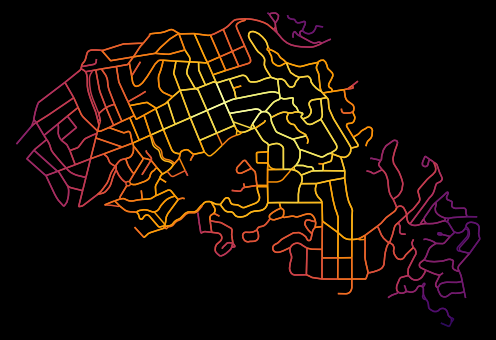

In [9]:
# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

## Routing

In [10]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [11]:
# get the nearest network nodes to two points
orig = ox.get_nearest_node(G, (37.828903, -122.245846))
dest = ox.get_nearest_node(G, (37.812303, -122.215006))

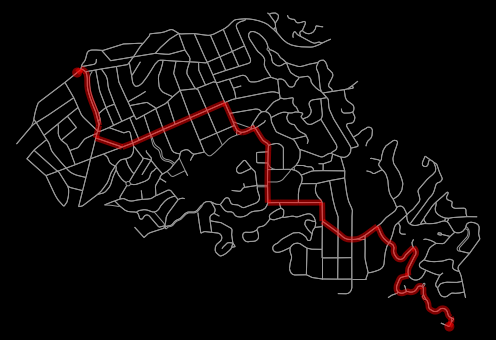

In [12]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [13]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

4789.3460000000005

In [14]:
# how far is it between these two nodes as the crow flies?
ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'],
                             G.nodes[dest]['y'], G.nodes[dest]['x'])

3123.7985450057035

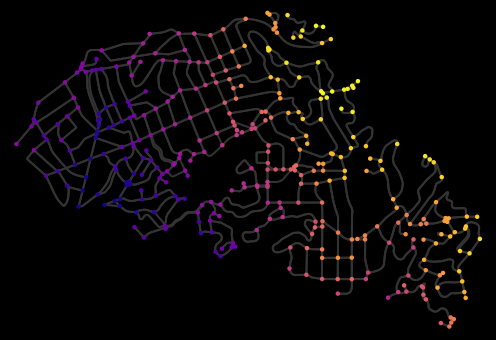

In [15]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
from keys import google_elevation_api_key
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G, fig_height=6, node_color=nc, node_size=20, node_zorder=2,
                        edge_linewidth=2, edge_color='#333333', bgcolor='k')

Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

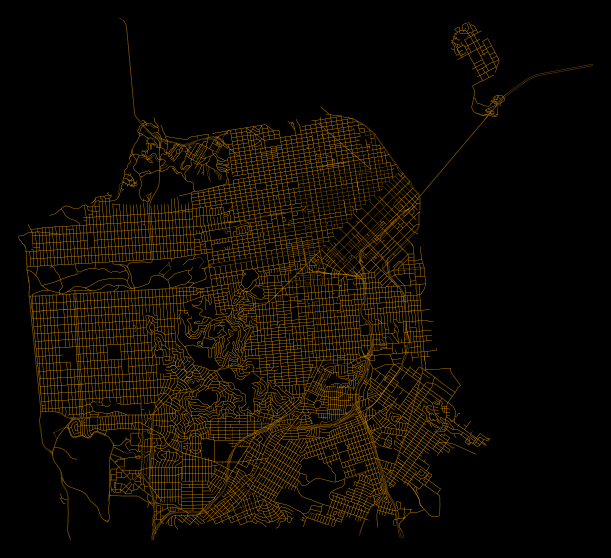

In [16]:
# you can make query an unambiguous dict to help the geocoder find it
place = {'city'   : 'San Francisco',
         'state'  : 'California',
         'country': 'USA'}
G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, fig_height=10, node_size=0, bgcolor='k',
                        edge_color='orange', edge_linewidth=0.2)

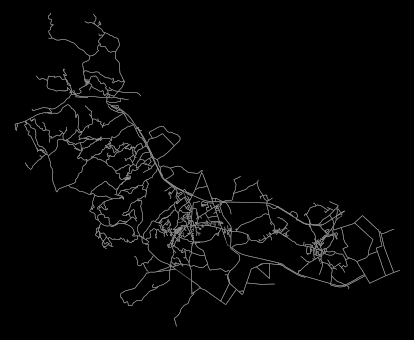

In [17]:
# you can get networks anywhere in the world
G = ox.graph_from_place('Sinalunga, Italy', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, bgcolor='k')

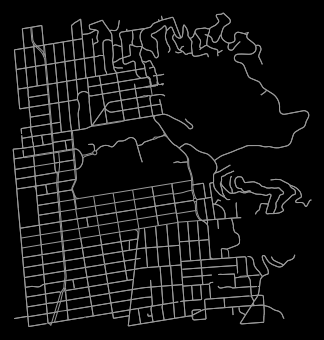

In [18]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609 #meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0, bgcolor='k')

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

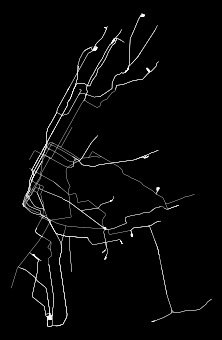

In [19]:
# get NY subway rail network
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2, bgcolor='k')

## Get points of interest

...such as local amenities or other entities: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.pois.pois_from_place).

In [20]:
# get everything tagged amenity,
# and everything with landuse = retail or commercial,
# and everything with highway = bus_stop
tags = {'amenity' : True,
        'landuse' : ['retail', 'commercial'],
        'highway' : 'bus_stop'}
gdf = ox.pois_from_place('Piedmont, California, USA', tags)
gdf.shape

(97, 90)

In [21]:
# view just the banks
gdf[gdf['amenity']=='bank'].dropna(axis=1, how='any')

,osmid,geometry,amenity,element_type,name,brand,brand:wikidata,brand:wikipedia
2810181540,2810181540,POINT (-122.23256 37.82515),bank,node,Citibank,Citibank,Q857063,en:Citibank
276424028,276424028,"POLYGON ((-122.23258 37.82491, -122.23252 37.8...",bank,way,Bank of America,Bank of America,Q487907,en:Bank of America
285549437,285549437,"POLYGON ((-122.23147 37.82466, -122.23134 37.8...",bank,way,Wells Fargo,Wells Fargo,Q744149,en:Wells Fargo


In [22]:
# view just the bus stops
gdf[gdf['highway']=='bus_stop'].dropna(axis=1, how='any').head()

,osmid,geometry,element_type,name,ref,bus,highway,network,public_transport,route_ref
4071030440,4071030440,POINT (-122.21517 37.81248),node,Park Boulevard & Saint James Drive,57544,yes,bus_stop,AC Transit,platform,V;33;688
5844909127,5844909127,POINT (-122.21392 37.81363),node,Park Boulevard & Estates Drive,54866,yes,bus_stop,AC Transit,platform,V;33;688
5845148873,5845148873,POINT (-122.21492 37.81822),node,Hampton Road & Sandringham Road,53832,yes,bus_stop,AC Transit,platform,33
5845152990,5845152990,POINT (-122.21459 37.81818),node,Hampton Road & Sandringham Road,50830,yes,bus_stop,AC Transit,platform,33
5845153014,5845153014,POINT (-122.22303 37.81763),node,Hampton Road & Seaview Avenue,53865,yes,bus_stop,AC Transit,platform,33
